In [6]:
%matplotlib widget
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from src.setup_OptiProblem import setup_OptiProblem
plt.style.use('ggplot')
plt.close("all")

df = pd.read_parquet("data/Qin_est.par")

In [7]:
zs = 2
N = 24
Ts = 5
mpc_controller = setup_OptiProblem(N,zs,Ts)

In [8]:
# =================== History Initialization ===================
# ==== Last element[-1]: latest; first[0]: oldest
h_hist = [150,150,150]
w_hist = np.vstack([[900,900,900],[0,0,0],[0,0,0]]).reshape(3,-1)
Qout_hist = [317,314,315]
E_hist = np.vstack([[0,0,0],[0,0,0],[0,0,0]]).reshape(3,-1)
P_hist = [1,0.9,0.8]
effi_hist = [0,0,0]

# construct pump trigger signal based on external schedule
trigger_k = np.zeros((3,10000))
trigger_k[0,:2000] = 1
# trigger_k[1,1600:3000] = 1
# trigger_k[2,2600:] = 1

# building some trajectory for Qin estimation
# Qin_k = np.hstack([np.ones(400)*300,np.arange(300, 2500, 40/Ts),np.ones(10)*2500, np.arange(2500, 300, -40/Ts),np.ones(10000)*300])
Qin_k = df["Qin_est"][200:].to_numpy()

# sine load:
# cycles = 2 # how many sine cycles
# resolution = 2100 # how many datapoints to generate
# length = np.pi * 2 * cycles
# Qin_k = np.sin(np.arange(0, length, length / resolution))*1200+1200

Qin_hist = Qin_k[0:3]

# building some trajectory for height reference
# h_ref_k = np.hstack([[150,150,150],np.arange(150, 145, (149-150)/(N+zs)), np.ones(10000)*145]) 
h_ref_k = np.ones(10000)*150
h_ref_hist = h_ref_k[0:zs] # history of reference for plotting, href_k cant be plotted because time horizon 

In [9]:
# =================== Measurement Updates and appending ===================
for k in range(2000):
    print(f"iteration : {k}")

    # Actual Solving
    # sol_w,sol_Qout,sol_h,sol_E,sol_P,sol_effi = mpc_controller(Qin_k[k+zs],Qout_hist[-3:],h_hist[-3:],w_hist[:,-3:],E_hist[:,-3:],P_hist[-3:],trigger_k[:,k+zs],h_ref_k[k:N+k+zs])
    sol_w,sol_Qout,sol_h,sol_E,sol_P,sol_effi = mpc_controller(Qin_k[k+zs],Qout_hist[-zs:],h_hist[-zs:],w_hist[:,-zs:],E_hist[:,-zs:],P_hist[-zs:],trigger_k[:,k+zs],h_ref_k[k:N+k+zs])
        
    h_meas_k = sol_h[zs].full().reshape(1)
    h_hist = np.hstack([h_hist, h_meas_k])

    w_meas_k = sol_w[:,zs].full()
    w_hist = np.hstack([w_hist, w_meas_k])

    Qout_meas_k = sol_Qout[zs].full().reshape(1)
    Qout_hist = np.hstack([Qout_hist, Qout_meas_k])  

    E_meas_k = sol_E[:,zs].full()
    E_hist = np.hstack([E_hist, E_meas_k])   

    P_meas_k = sol_P[zs].full().reshape(-1)
    P_hist = np.hstack([P_hist, P_meas_k]) 

    effi_k = sol_effi[zs].full().reshape(-1)
    effi_hist = np.hstack([effi_hist, effi_k])   

    h_ref_hist = np.hstack([h_ref_hist, h_ref_k[k+zs]])   
    
    Qin_hist = np.hstack([Qin_hist, Qin_k[k+zs]])   


iteration : 0
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 114.00us (  9.50us) 112.30us (  9.36us)        12
       nlp_g  | 335.00us ( 27.92us) 246.20us ( 20.52us)        12
  nlp_grad_f  | 165.00us ( 12.69us) 160.60us ( 12.35us)        13
  nlp_hess_l  | 132.00us ( 12.00us) 126.60us ( 11.51us)        11
   nlp_jac_g  | 285.00us ( 21.92us) 288.50us ( 22.19us)        13
       total  |  33.58ms ( 33.58ms)  33.41ms ( 33.41ms)         1
iteration : 1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 257.00us ( 10.71us) 217.20us (  9.05us)        24
       nlp_g  | 608.00us ( 25.33us) 466.60us ( 19.44us)        24
    nlp_grad  |  31.00us ( 31.00us)  31.70us ( 31.70us)         1
  nlp_grad_f  | 375.00us ( 14.42us) 365.10us ( 14.04us)        26
  nlp_hess_l  | 239.00us ( 10.86us) 229.80us ( 10.45us)        22
   nlp_jac_g  | 571.00us ( 21.96us) 575.30us ( 22.13us)        26
       total  |  31.00ms ( 31.00ms)  30.79ms ( 3

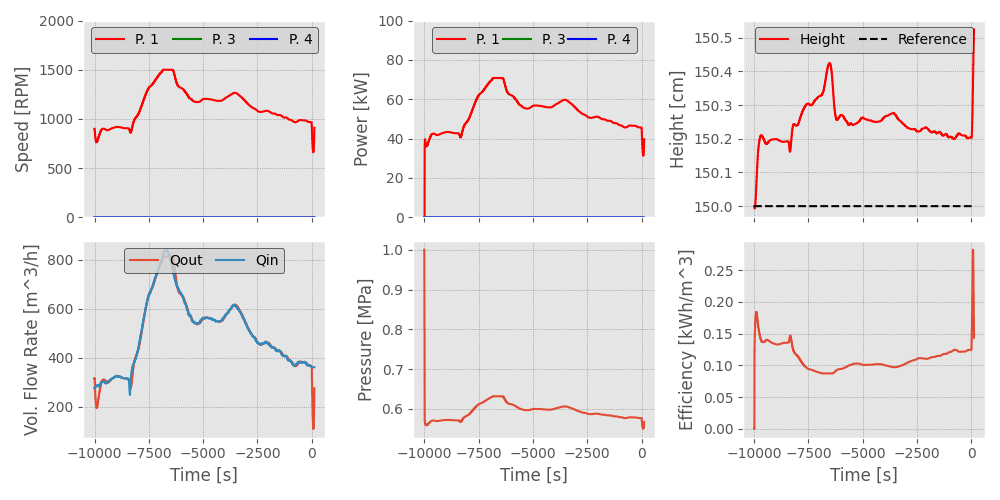

In [10]:
time = np.arange((-h_hist.shape[0]+2)*Ts, (N+1)*Ts,Ts)
fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=False)

# Plot 1 - Speed [RPM]
axs[0, 0].step(time,np.hstack([w_hist[0, :],sol_w[0,zs+1:].full().reshape(-1)]), "r", label='P. 1',where='post')
axs[0, 0].step(time,np.hstack([w_hist[1, :],sol_w[1,zs+1:].full().reshape(-1)]), "g", label='P. 3',where='post')
axs[0, 0].step(time,np.hstack([w_hist[2, :],sol_w[2,zs+1:].full().reshape(-1)]), "b", label='P. 4',where='post')
axs[0, 0].set_ylim([0, 2000])
axs[0, 0].set_ylabel('Speed [RPM]')
axs[0, 0].grid(linestyle=':', linewidth='0.5', color='gray')
axs[0, 0].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')


# Plot 2 - Power [kW]
axs[0, 1].step(time,np.hstack([E_hist[0, :],sol_E[0,zs+1:].full().reshape(-1)]), "r", label='P. 1',where='post')
axs[0, 1].step(time,np.hstack([E_hist[1, :],sol_E[1,zs+1:].full().reshape(-1)]), "g", label='P. 3',where='post')
axs[0, 1].step(time,np.hstack([E_hist[2, :],sol_E[2,zs+1:].full().reshape(-1)]), "b", label='P. 4',where='post')
axs[0, 1].set_ylabel('Power [kW]')
axs[0, 1].grid(linestyle=':', linewidth='0.5', color='gray')
axs[0, 1].set_ylim([0, 100])
axs[0, 1].legend(loc='upper center', columnspacing=0.2, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# Plot 3 - Height
axs[0, 2].step(time,np.hstack([h_hist,sol_h[zs+1:].full().reshape(-1)]), "r", label='Height',where='post')
axs[0, 2].step(time,h_ref_k[:h_hist.shape[0]+N-1], "k--", label='Reference',where='post')
axs[0, 2].set_ylabel("Height [cm]")
axs[0, 2].grid(linestyle=':', linewidth='0.5', color='gray')
# axs[0, 2].set_ylim([0, 250])
axs[0, 2].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# Plot 4 - Volumetric Flow Rate
axs[1, 0].step(time,np.hstack([Qout_hist,sol_Qout[zs+1:].full().reshape(-1)]), label='Qout',where='post')
axs[1, 0].step(time,np.hstack([Qin_hist, np.ones(sol_Qout[zs+1:].shape[0])*Qin_hist[-1]]), label='Qin',where='post')
axs[1, 0].set_ylabel("Vol. Flow Rate [m^3/h]")
axs[1, 0].set_xlabel("Time [s]")
axs[1, 0].grid(linestyle=':', linewidth='0.5', color='gray')
# axs[1, 0].set_ylim([0, 800])
axs[1, 0].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# Plot 5 - Pressure
axs[1, 1].step(time,np.hstack([P_hist,sol_P[zs+1:].full().reshape(-1)]), label='Pressure',where='post')
axs[1, 1].set_ylabel("Pressure [MPa]")
axs[1, 1].set_xlabel("Time [s]")
axs[1, 1].grid(linestyle=':', linewidth='0.5', color='gray')

# Plot 6 - effi
axs[1, 2].step(time,np.hstack([effi_hist,sol_effi[zs+1:].full().reshape(-1)]), label='Qout',where='post')
axs[1, 2].grid(linestyle=':', linewidth='0.5', color='gray')
axs[1, 2].set_ylabel("Efficiency [kWh/m^3]")
axs[1, 2].set_xlabel("Time [s]")


plt.tight_layout()
plt.show()
